In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
from multiprocessing import  Pool
from astropy.io import ascii
from glob import glob
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
from time import sleep
# Import
from pandarallel import pandarallel
# Initialization
pandarallel.initialize(nb_workers=6)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
all_stars = Table.read('../../HST_Guido/30dor_all_newerr.UBVIHa.rot', format='ascii').to_pandas()
all_stars.columns = 'ID;x;y;RA;Dec;u_1;eu_2;b_1;eb_2;v_1;ev_2;i_1;ei_2;ha_1;eha_2'.split(';')
all_stars = all_stars.set_index('ID')
all_stars = all_stars[(all_stars['ha_1']>5)&(all_stars['ha_1']<50)]
all_stars = all_stars[(all_stars['v_1']>5)&(all_stars['v_1']<50)]
all_stars = all_stars[(all_stars['i_1']>5)&(all_stars['i_1']<50)]

In [3]:
red_giants = ascii.read('../../HST_Guido/redgiants_coords.txt').to_pandas()
red_giants = all_stars.loc[red_giants.ID]

In [4]:
pms = ascii.read('../../HST_Guido/30dorallpmsstars.txt').to_pandas()
distances = np.sqrt((pms.X.values - all_stars.x.values[:,np.newaxis])**2+(pms.Y.values - all_stars.y.values[:,np.newaxis])**2).T
argmins  = np.argmin(distances, axis=1)
mindists = np.min(distances, axis=1)
argmins = argmins[mindists<1]
pms_stars = all_stars.iloc[argmins]

In [5]:
distances = np.sqrt((pms.X.values - all_stars.x.values[:,np.newaxis])**2+(pms.Y.values - all_stars.y.values[:,np.newaxis])**2).T
distances = pd.DataFrame(distances, index=pms.index, columns = all_stars.index)
pms_id_argmins  = distances.idxmin(axis=0)#np.argmin(distances, axis=0)
mindists = distances.min(axis=0)#np.min(distances, axis=0)
#argmins = argmins[mindists<1.5
argmins = np.argmin(distances.values, axis=0)[mindists<1]
pms_id_argmins = pms_id_argmins[mindists<1]
pms = pms.iloc[argmins]
pms['AssocID'] = pms_id_argmins.index
pms = pms.set_index('AssocID').drop('NR', axis=1)
pms

,X,Y,V,eV,I,eI,Ha,eHa,LgT,eLgT,LgL,eLgL,LgHa,EW,Mass,Age,LgMdot
AssocID,,,,,,,,,,,,,,,,,
39,1515.66,778.65,11.82,0.01,11.58,0.01,10.84,0.01,3.90,0.03,4.60,0.06,1.68,-16.1,0.0,0.0,9.99
151,3799.66,4212.51,13.63,0.01,13.80,0.01,13.03,0.00,4.17,0.16,4.34,0.17,0.74,-11.9,4.9,0.5,-4.27
181,3242.22,2950.02,13.73,0.01,13.69,0.01,12.30,0.00,3.96,0.04,3.87,0.07,1.25,-43.0,0.0,0.0,9.99
202,3569.54,2491.61,13.27,0.02,13.73,0.03,11.75,0.00,4.54,3.73,5.30,3.73,1.51,-61.9,3.4,0.4,-3.62
325,3780.93,2483.78,14.25,0.00,13.86,0.00,11.25,0.00,3.86,0.03,3.64,0.07,1.77,-169.6,0.0,0.0,9.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21141,1945.35,379.54,23.80,0.06,22.54,0.03,21.32,0.17,3.66,0.02,0.03,0.06,-2.35,-46.1,1.0,3.0,-7.81
21268,2405.28,2920.34,24.33,0.07,22.97,0.02,20.59,0.14,3.64,0.02,-0.13,0.06,-1.97,-172.1,0.9,3.7,-7.43
21291,2896.09,1965.39,23.99,0.06,22.80,0.03,19.60,0.11,3.67,0.02,-0.07,0.06,-1.55,-371.2,1.0,5.1,-7.10


<h3>Classes and definitions</h3>

In [36]:
f=np.sort([w.split('_flt')[0] for w in glob('../SingleFrame_DetRegrid/WFC'+str(1)+'/*phot.fits')])[10]
glob(f.replace('WFC1', 'WFC1_crcleaned')+'_crclean_rate_wfc1.fits')

['../SingleFrame_DetRegrid/WFC1_crcleaned/ib6wd1sqq_crclean_rate_wfc1.fits']

In [68]:
################################################################
### Read from unaltered FLT frames with regridded whitelights###
################################################################
class read_sexcats():
    def __init__(self):
        phot_df = self.join(1)
        self.phot_df = self.join(2, phot_df)
        #phot_df = self.return_func(phot_df)
        
    def join(self, wfc, phot_df=None):
        items = np.sort([w.split('_flt')[0] for w in glob('../SingleFrame_DetRegrid/WFC'+str(wfc)+'/*phot.fits')])
        items = items
        for iterator in range(len(items)):
            item = items[iterator]
            hdul = fits.open(glob(item+'*pamcorr_rate*fits')[0])
            expstart = hdul[0].header['EXPSTART']
            EXPTIME  = hdul[0].header['EXPTIME']
            if EXPTIME < 31: # For now skip all short exposures
                continue
            fitsfilename = glob(item.replace('WFC'+str(wfc), 'WFC'+str(wfc)+'_crcleaned')+'_crclean_rate_wfc*.fits')[0]
            hdul = fits.open(fitsfilename)
            filter_  = hdul[0].header['FILTER']
            filename = glob(item+'*phot*')[0]
            sexcat = Table.read(filename, format="fits", hdu='LDAC_OBJECTS')#.to_pandas()
            if 'VIGNET' in sexcat.columns:
                vignet = sexcat['VIGNET'].data
                sexcat.remove_columns('VIGNET')
            sexcat = self.unpack_apers(sexcat)
            sexcat.remove_columns(['MAG_APER', 'MAGERR_APER', 'FLUX_APER', 'FLUXERR_APER'])    
            sexcat = sexcat.to_pandas()

            sexcat = sexcat.rename(columns={'NUMBER':'SExID'})
            sexcat = sexcat.rename(columns={'VECTOR_ASSOC':'AssocID'})
            #sexcat['AssocID'] = 1
            sexcat['Filename'] = fitsfilename#filename.replace('phot', 'pamcorr_rate')
            sexcat['AssocID'] = sexcat['AssocID'].astype(int)
            sexcat = sexcat[sexcat.AssocID!=0]
            
            sexcat['SEx_ALPHA_J2000'] = sexcat['ALPHA_J2000'].values
            sexcat['SEx_DELTA_J2000'] = sexcat['DELTA_J2000'].values
            
            sexcat['ALPHA_J2000'] = all_stars.loc[sexcat['AssocID'].values].RA.values
            sexcat['DELTA_J2000'] = all_stars.loc[sexcat['AssocID'].values].Dec.values
            
            if wfc==2: 
                sexcat.SExID += phot_df[phot_df.WhichWFC==1].SExID.max()
            #sexcat = sexcat.rename(columns={'VECTOR_ASSOC':'ID'})

            sexcat['T_Start'] = expstart
            sexcat['Exptime'] = EXPTIME
            sexcat['Exp_Length'] = ('deep' if EXPTIME > 31 else 'short')
            sexcat['Filter']     = filter_
            sexcat['WhichWFC']   = wfc
            sexcat = self.clean(sexcat)
            #sexcat = sexcat.set_index('ID')
            try:
                phot_df = pd.concat((phot_df,sexcat), axis=0)
            except:
                phot_df = sexcat
        return phot_df
        
    def return_func(self):
        print('Done. Returning photometry dataframe')
        return self.phot_df.set_index(['AssocID', 'Filter', 'T_Start']).sort_index()
    
    def clean(self, sexcat):
        """I take all rules from the HCV catalogue"""
        sexcat = sexcat[(sexcat.MAG_APER2<80)&(sexcat.MAG_AUTO<80)]
        sexcat = sexcat[sexcat.MAG_APER2<31.0]
        sexcat = sexcat[sexcat.MAG_AUTO<35.0]
        sexcat = sexcat[sexcat.FLAGS<7]
        sexcat = sexcat[sexcat.FLAGS_WEIGHT!=1]#==0]
        sexcat = sexcat[sexcat.MAGERR_APER2<1]
        return sexcat
    
    def unpack_apers(self, sexcat):
        """Unpacking the stacked lists
           NOTES:
           APER1 and APER2 refer to Whitmore et al 2016 (2.5 and 7.5 pixels diameter)
           APER3 refers to our own aperture, which is 6 pixels in diameter
           """
        sexcat['FLUX_APER1'] = [w[0] for w in sexcat['FLUX_APER']]
        sexcat['FLUX_APER3'] = [w[1] for w in sexcat['FLUX_APER']]
        sexcat['FLUX_APER2'] = [w[2] for w in sexcat['FLUX_APER']]
        #sexcat['FLUX_BGInner'] = [w[3] for w in sexcat['FLUX_APER']]
        #sexcat['FLUX_BGOuter'] = [w[4] for w in sexcat['FLUX_APER']]
        sexcat['FLUXERR_APER1'] = [w[0] for w in sexcat['FLUXERR_APER']]
        sexcat['FLUXERR_APER3'] = [w[1] for w in sexcat['FLUXERR_APER']]
        #sexcat['FLUXERR_BGInner'] = [w[3] for w in sexcat['FLUXERR_APER']]
        #sexcat['FLUXERR_BGOuter'] = [w[4] for w in sexcat['FLUXERR_APER']]
        #sexcat['FLUXERR_APER2'] = [w[3] for w in sexcat['FLUXERR_APER']]
        #sexcat['FLUXERR_APER2'] = [w[4] for w in sexcat['FLUXERR_APER']]

        sexcat['MAG_APER1'] = [w[0] for w in sexcat['MAG_APER']]
        sexcat['MAG_APER3'] = [w[1] for w in sexcat['MAG_APER']]
        sexcat['MAG_APER2'] = [w[2] for w in sexcat['MAG_APER']]
        #sexcat['MAG_BGInner'] = [w[3] for w in sexcat['MAG_APER']]
        #sexcat['MAG_BGOuter'] = [w[4] for w in sexcat['MAG_APER']]
        sexcat['MAGERR_APER1'] = [w[0] for w in sexcat['MAGERR_APER']]
        sexcat['MAGERR_APER3'] = [w[1] for w in sexcat['MAGERR_APER']]
        sexcat['MAGERR_APER2'] = [w[2] for w in sexcat['MAGERR_APER']]
        #sexcat['MAGERR_BGInner'] = [w[3] for w in sexcat['MAGERR_APER']]
        #sexcat['MAGERR_BGOuter'] = [w[4] for w in sexcat['MAGERR_APER']]
        return sexcat


In [69]:
class HCV_error_analysis():
    def __init__(self, phot_df):
        phot_df = phot_df.drop(phot_df.index[phot_df.ALPHA_J2000.isna()])
        phot_df = phot_df.drop(phot_df.index[phot_df.BACKGROUND<0])
        zmag  = {'F336W':23.46,'F438W':24.98,'F555W': 25.81, 'F814W': 24.67, 'F656N': 19.92}
        skymags = -2.5*np.log10(phot_df['BACKGROUND'])+[zmag[w] for w in phot_df.index.get_level_values(1)]#.hist(bins=np.arange(-10,10,0.1))
        phot_df = phot_df.drop(phot_df.index[(skymags - phot_df.MAG_APER2)<0.5])
        self.phot_df = phot_df
        return

    def get_CI(self,phot_df):
        CI = phot_df['MAG_APER1'] - phot_df['MAG_APER2']
        phot_df['CI'] = CI
        return phot_df

    def get_synthetic_err(self,phot_df):
        """Following the approach of the HCV paper"""
        # I take the median, but note that there is always only ONE count, thus median = value
        MagerrAper2  = phot_df.groupby(['AssocID', 'Filter','T_Start'])['MAGERR_APER2'].median()
        MagerrAper2_timemedian = phot_df.groupby(['AssocID', 'Filter'])['MAGERR_APER2'].median()
        MagDivision = (MagerrAper2 / MagerrAper2_timemedian)**2
        
        CI_timemedian = phot_df.CI.groupby(['AssocID', 'Filter']).median()
        CIDivision    = (phot_df.CI / CI_timemedian)**2
        
        MagAper_MagAuto = (phot_df.MAG_APER2 - phot_df.MAG_AUTO)
        MagAper_MagAuto_timemedian = MagAper_MagAuto.groupby(['AssocID', 'Filter']).median()
        MagAper_MagAutoDivision = (MagAper_MagAuto/MagAper_MagAuto_timemedian)**2
        
        RATimemedian = phot_df.groupby(['AssocID', 'Filter', 'T_Start'])['SEx_ALPHA_J2000'].median()
        DECTimemedian = phot_df.groupby(['AssocID', 'Filter', 'T_Start'])['SEx_DELTA_J2000'].median()

        RAs = phot_df.groupby(['AssocID','Filter'])['SEx_ALPHA_J2000'].median()
        DECs = phot_df.groupby(['AssocID', 'Filter'])['SEx_DELTA_J2000'].median()

        DeltaRAs = np.power(RAs - RATimemedian,2)
        DeltaDECs = np.power(DECs - DECTimemedian,2)

        Dists = np.sqrt(DeltaRAs+DeltaDECs)
        DistsTimemedian = Dists.groupby(['AssocID', 'Filter']).median()
        DistsDivision   = (Dists/DistsTimemedian)**2
        
        BgTimeMedian = phot_df.groupby(['AssocID', 'Filter', 'T_Start'])['BACKGROUND'].median()
        BgMedian     = phot_df.groupby(['AssocID', 'Filter'])['BACKGROUND'].median() 
        BgDeviation  = (BgTimeMedian / BgMedian -1)**2
        self.BgDeviation = BgDeviation
        
        SynError = np.sqrt(MagDivision + CIDivision + MagAper_MagAutoDivision + BgDeviation + DistsDivision)
        phot_df['SynError'] = SynError
        return phot_df
    
    def linfit(self,x,b):
        return 1/np.inf*x+b
    
    def get_sigma_prime(self, phot_df):
        StarIDs = phot_df.get_level_values(0).unique()
        for StarID in StarIDs:
            filters = phot_df.loc[StarIDs].index.get_level_values(0).unique()
    
    
    
    def get_synthetic_err_deviation(self, phot_df):
        SynErrorSTD = phot_df.groupby(['AssocID', 'Filter'])['SynError'].std() # Standard deviation of synthetic errors
        SynErrorMed = phot_df.groupby(['AssocID', 'Filter'])['SynError'].median() # median of synthetic errors
        SynErrorDev = (phot_df.SynError-SynErrorMed).abs()/SynErrorSTD # How many sigma is this measurement removed from the median
        phot_df['SynErrorDevSig'] = SynErrorDev.values
        phot_df['SynErrorMed'] = SynErrorMed
        phot_df['SynErrorSig'] = phot_df.SynError / SynErrorMed
        phot_df['High_sigma_syn'] = phot_df['SynErrorSig'] > 4
        return phot_df
    
    
    def robust_mean(self,mags, synerrs):
        mags = mags.values
        synerrs = synerrs.values
        synerrs = synerrs[np.argsort(mags)]
        mags = np.sort(mags)
        if len(mags)>5:
            to_drop = (len(mags)//6)
            mags = mags[to_drop:-to_drop]
            synerrs = synerrs[to_drop:-to_drop]
        weighted_mean = np.nansum(1/synerrs**2 * mags) / np.nansum(1/synerrs**2)
        return weighted_mean, np.sqrt(np.mean(np.power(mags-weighted_mean,2)))
    
    def get_mean_sigmaprime(self, phot_df):
        """This will take some time"""
        StarIDs = phot_df.index.get_level_values(0).unique().values
        phot_df['RobustMean'] = 0
        phot_df['RobustSigma'] = 0
        i=0
        for StarID in StarIDs:
            filters = phot_df.loc[StarID].index.get_level_values(0).unique()
            for this_filter in filters:
                sub_phot_df = phot_df.loc[StarID,this_filter]
                Lightcurve_SynErrors = sub_phot_df.SynError
                Lightcurve_mags = sub_phot_df.MAG_APER2
                TrueMag, SigmaPrime = self.robust_mean(Lightcurve_mags, Lightcurve_SynErrors)
                phot_df.loc[(StarID, this_filter,),'RobustMean'] = TrueMag
                phot_df.loc[(StarID, this_filter,),'RobustSigma']= SigmaPrime
        phot_df['SigmaPrimeDeviation'] = (phot_df['MAG_APER2'] - phot_df['RobustMean']).abs() / phot_df['RobustSigma']
        phot_df['High_sigma_prime'] = phot_df['SigmaPrimeDeviation'] > 4
        return phot_df
    
    def parallelize_df(self,df, func, n_cores=4):
        df_split = np.array_split(df, n_cores)
        pool = Pool(n_cores)
        df = pd.concat(pool.map(func, df_split))
        pool.close()
        pool.join()
        return df
    
        
    def get_local_mzp_corr(self, phot_df):
        phot_df['MagDiff'] = phot_df['MAG_APER2'] - phot_df['RobustMean']
        nearest = nearest_neighbours(phot_df)
        phot_df = phot_df[phot_df.Exp_Length == 'deep'].copy()
        
        IDs = phot_df.index.get_level_values(0).unique()
        phot_df['MZPCorr']=0
        for ID in IDs:
            neightbours = nearest.loc[ID]
            photometry = phot_df.loc[neightbours.values]
            MagOffset = photometry.groupby(['Filter', 'T_Start'])['MagDiff'].median()
            MagOffset = pd.DataFrame(MagOffset)
            MagOffset.columns = ['MZPCorr2']
            phot_df.loc[ID,'MZPCorr'] = pd.DataFrame(phot_df.loc[ID]).join(MagOffset)['MZPCorr2'].values
        phot_df['MAG_APER2_ORIG'] = phot_df['MAG_APER2']
        phot_df['MAG_APER2'] = phot_df['MAG_APER2'] - phot_df['MZPCorr']
        return phot_df
    
    def clean(self, MZPcorr=False):
        phot_df = self.get_CI(self.phot_df)
        phot_df = self.get_synthetic_err(phot_df)
        phot_df = self.get_synthetic_err_deviation(phot_df)
        phot_df = self.parallelize_df(phot_df,self.get_mean_sigmaprime)
        # Measurements with extreme varying background are probably not good!
        phot_df = phot_df[self.BgDeviation<0.5]
        if MZPcorr:
            phot_df = self.parallelize_df(phot_df, self.get_local_mzp_corr)#.get_local_mzp_corr(phot_df)
        phot_df = phot_df[phot_df.CI < 5]
        phot_df = phot_df[(np.logical_not(phot_df.High_sigma_prime))*(np.logical_not(phot_df.High_sigma_syn))]
        print('Done. Returning photometry dataframe including CI and synthetic errors and MZP correction')
        return phot_df


In [70]:
def SExToCat(phot_df, cat):
    SExCoordinates = phot_df.groupby('AssocID')['ALPHA_J2000', 'DELTA_J2000'].median()
    CatCoordinates = all_stars[['RA', 'Dec']]
    DeltaRA  = np.power(SExCoordinates.ALPHA_J2000.values - CatCoordinates.RA.values[:,np.newaxis],2, dtype=np.float32).T
    DeltaDec = np.power(SExCoordinates.DELTA_J2000.values - CatCoordinates.Dec.values[:,np.newaxis],2, dtype=np.float32).T
    Dists    = np.sqrt(DeltaRA + DeltaDec)
    Dists[Dists>1e-4] = np.nan
    del DeltaRA, DeltaDec
    Dists     = pd.DataFrame(Dists, index = SExCoordinates.index, columns=all_stars.index)
    Assoc_df  = pd.DataFrame({'RefCatID':Dists.idxmin(axis=1)})
    return Assoc_df.dropna()
def nearest_neighbours(phot_df, Nstars = 50):
    catalogue = phot_df.groupby('AssocID')['ALPHA_J2000', 'DELTA_J2000'].median()
    Nentries = len(catalogue)
    
    deltaRA  = np.memmap('deltaRA.temp' , dtype='float64', mode='w+', shape=(Nentries,Nentries))
    deltaDEC = np.memmap('deltaDec.temp', dtype='float64', mode='w+', shape=(Nentries,Nentries))
    
    deltaRA[:]  = catalogue.ALPHA_J2000.values - catalogue.ALPHA_J2000.values[:,np.newaxis]
    deltaDEC[:] = catalogue.DELTA_J2000.values - catalogue.DELTA_J2000.values[:,np.newaxis]
    
    deltaAngle = deltaRA**2 + deltaDEC**2
    del deltaRA, deltaDEC
    
    nearest = catalogue.index.values[np.argsort(deltaAngle, axis=1)] # To correct for ID <-> argument
    nearest = pd.DataFrame(nearest[:,1:Nstars+1], index=catalogue.index)
    return nearest

In [71]:
class Analysis():
    def __init__(self, phot_df):
        self.ApplySelection(phot_df)
        return

    def ApplySelection(self, phot_df):
        self.phot_df = phot_df#[phot_df.SynErrorDevSig<=20]
        self.phot_df = self.phot_df[self.phot_df.Exp_Length=='deep']
    
    def GetMADvalues(self):
        phot_df          = self.phot_df
        MedianMagTime    = phot_df.groupby(['AssocID', 'Filter', 'T_Start'])['MAG_APER2'].median()
        MedianMagOverall = phot_df.groupby(['AssocID', 'Filter'])['RobustMean'].median()
        MagOffset        = (MedianMagTime - MedianMagOverall).abs()
        self.MAD         = MagOffset.groupby(['AssocID', 'Filter']).median()
        return self.MAD
    
    def GetMinMaxvalues(self):
        phot_df          = self.phot_df
        MaxMagnitude     = phot_df.groupby(['AssocID', 'Filter'])['MAG_APER2'].max()
        MinMagnitude     = phot_df.groupby(['AssocID', 'Filter'])['MAG_APER2'].min()
        MinMagMagnitude  = (MaxMagnitude - MinMagnitude).abs()
        self.MinMag      = MinMagMagnitude.groupby(['AssocID', 'Filter']).median()
        return self.MinMag
    
    def GetMedMags(self):
        self.MedMag = self.phot_df.groupby(['AssocID', 'Filter'])['MAG_APER2'].median()
        return self.MedMag

    def GetMedMagErr(self):
        self.MedMagErr = self.phot_df.groupby(['AssocID', 'Filter'])['MAGERR_APER2'].median()
        return self.MedMagErr

    
    def GetMADPlot(self, filter_=None):
        self.GetMADvalues()
        self.MAD.hist(bins=np.arange(0,1,0.002),cumulative=False, histtype='step', normed=False, linewidth=2)
        plt.xlabel('MAD Value')
        plt.ylabel('PDF')
        plt.show()
        
        self.MAD.hist(bins=np.arange(0,1,0.002),cumulative=True, histtype='step', normed=True, linewidth=2)
        plt.xlabel('MAD Value')
        plt.ylabel('CDF')
        plt.show()
        
        self.GetMedMags()
        if filter_ !=None:
            med_mags = self.MedMag[self.MedMag.index.get_level_values(1)==filter_]
            mad_vals = self.MAD[self.MAD.index.get_level_values(1)==filter_]
        else:
            med_mags = self.MedMag#[self.MedMag.index.get_level_values(1)==filter_]
            mad_vals = self.MAD#[self.MAD.index.get_level_values(1)==filter_]
        plt.hist2d(med_mags, mad_vals, bins=(np.linspace(15,28,80), np.linspace(0,0.4,50)), cmap=plt.cm.jet)
        plt.xlabel('Median magnitude')
        plt.ylabel('MAG Value')
        plt.show()
        
    
    def DrawTrumpets(self,magcol = 'MAG_APER3', IDcol = 'AssocID'):
        phot_df = self.phot_df
        merrcol = magcol.replace('MAG', 'MERR')
        # Trumpet plot
        from matplotlib.colors import LogNorm
        magnitudes = phot_df[magcol]
        filters = magnitudes.index.get_level_values(1).unique()
        plt.figure(figsize=(20,10))
        num=0
        for filter_ in np.sort(filters):
            epochs  = magnitudes.loc[:,filter_,:].index.get_level_values(1).unique()
            mags_t0 = pd.DataFrame(magnitudes.loc[:, filter_, epochs[0], :])
            num+=1
            plt.subplot('23'+str(num))
            xs, ys = np.array([]), np.array([])
            for i in range(len(epochs)-1):
                mags_t1 = pd.DataFrame(magnitudes.loc[:, filter_, epochs[i+1], :])
                join_mags = mags_t0.join(mags_t1, lsuffix = '_t0', rsuffix='_t1', how='inner')
                join_mags['DeltaMag'] = join_mags[magcol+'_t1'] - join_mags[magcol+'_t0']
                median_mags = magnitudes.loc[:, filter_, :].groupby([IDcol]).median()
                join_mags = join_mags.join(median_mags)
                x, y = join_mags[magcol].values, join_mags['DeltaMag'].values
                x, y = x[np.isfinite(x)*np.isfinite(y)], y[np.isfinite(x)*np.isfinite(y)]
                xs = np.hstack((xs,x))
                ys = np.hstack((ys,y))
            plt.hist2d(xs, ys, bins=(np.linspace(15,28,80), np.linspace(-3,3,150)), cmap='jet', cmin=15)
            plt.title(filter_, pad=-15)
            plt.ylabel('Delta Mag')
            plt.xlabel('Median magnitude')
            plt.ylim(-1,1)
            plt.xlim(14,27)
            if num in [1,4,7]:
                plt.ylabel('Delta Mag')
            else:
                plt.yticks([])
            if num in [4,5]:
                plt.xlabel('Median magnitude')
            else:
                plt.xticks([])
            plt.ylim(-1.5,1.5)
        plt.tight_layout()
        #plt.savefig('trumpet_diagrams.png', dpi=500)
        plt.show()

    def MAG_pdf(self, magcol = 'MAG_APER2',fluxcol='FLUX_APER2', IDcol = 'AssocID'):
        phot_df = self.phot_df
        fig, ax = plt.subplots(figsize=(10,6))
        for name, group in phot_df[phot_df[fluxcol]>0].groupby('Filter')[magcol]:
            group.hist(bins=np.arange(15,30,0.1), histtype='step', ax=ax, normed=True, label=name, linewidth=2)
        ax.legend()
        ax.set_xlabel('Magnitude')
        ax.set_ylabel('Normalized frequency')
        ax.set_xlim(15,30)
        plt.show()


        fig, ax = plt.subplots(figsize=(10,6))
        for name, group in phot_df[phot_df[fluxcol]>0].groupby('Filter')[magcol]:
            group.hist(bins=np.arange(15,30,0.1),cumulative=True, histtype='step', ax=ax, normed=True, label=name, linewidth=2)
        ax.legend()
        ax.set_xlabel('Magnitude')
        ax.set_ylabel('Normalized frequency')
        ax.set_xlim(15,30)
        plt.show()
    
    def GetNumberOfMeasurements(self):
        counts = self.phot_df['MAG_APER2'].groupby(['AssocID', 'Filter']).count()
        return counts
    
    def GetTimeSeries(self, AssocID = None, Filter=None):
        if not AssocID:
            MinMeasurements = 10
            WhichEntries    = self.GetNumberOfMeasurements()>MinMeasurements
            WhichEntries    = WhichEntries[WhichEntries]
            RandomRow       = np.random.randint(0,len(WhichEntries))
            AssocID         = WhichEntries.index.get_level_values(0)[RandomRow]
            Filter          = WhichEntries.index.get_level_values(1)[RandomRow]
        JulianDates = self.phot_df.loc[AssocID, Filter].reset_index().T_Start
        Magnitudes  = self.phot_df.loc[AssocID, Filter].MAG_APER2
        Synth_err   = self.phot_df.loc[AssocID, Filter].SynErrorDevSig
        MAG_err     = self.phot_df.loc[AssocID, Filter].MAGERR_APER2
        
        plt.figure(figsize=(8,5))
        plt.title('AssocID ' +str(AssocID) + ' ' +Filter + ' mag ' +np.round(self.phot_df.loc[AssocID, Filter]['RobustMean'].median(),3).astype(str))
        plt.errorbar(JulianDates, Magnitudes, yerr=MAG_err, linestyle='none', fmt='o', ecolor='black', capthick=2)
        #plt.scatter(JulianDates, Magnitudes, marker='o', c='black')
        return JulianDates.values, Magnitudes.values, MAG_err.values
        plt.show()
        

    def median_mad_sigma(self):
        mags, mads = self.GetMedMags(), self.GetMADvalues()  
        mags = pd.DataFrame(mags)
        mags.columns = ['MAG']
        mads = pd.DataFrame(mads)
        mads.columns = ['MAD']
        # Drop first 0.5 mag and last 0.5 mag
        lower_thres = pd.DataFrame(mags.groupby('Filter').min()+0.5)#FilterMags.min()+0.5
        lower_thres.columns = ['LowerMagThresh']
        upper_thres = pd.DataFrame(mags.groupby('Filter').max()-0.5)##FilterMags.max()-0.5
        upper_thres.columns = ['UpperMagThresh']

        mags = pd.merge(mags, lower_thres, left_index=True,left_on='Filter', right_index=True)#, right_on='Filter')
        mags = pd.merge(mags, upper_thres, left_index=True,left_on='Filter', right_index=True)

        mags = mags[(mags.MAG>mags.LowerMagThresh)*(mags.MAG<mags.UpperMagThresh)]
        MagsMads = mags.copy()
        MagsMads = MagsMads.join(mads)

        MagsMads['MagBin'] = pd.cut(MagsMads['MAG'], bins=20)
        MedMadBin = pd.DataFrame(MagsMads.groupby('MagBin')['MAD'].median())
        MedMadBin.columns = ['MedMadBin']
        MagsMads = pd.merge(MagsMads,MedMadBin, left_on='MagBin', right_index=True)

        MagsMads['MADSigma'] = MagsMads['MAD'] / MagsMads['MedMadBin']
        return MagsMads
    
    def potential_candidates(self):
        MagsMads = self.median_mad_sigma()
        PotCandidates = MagsMads['MAD'].unstack()
        PotCandidates['NFilters'] = PotCandidates.count(axis=1)
        return PotCandidates
    
    def inspect(self,AssocID, Filter):
        local_phot_df = self.phot_df.loc[AssocID, Filter]
        local_phot_df = local_phot_df.sort_index()
        files = local_phot_df.Filename.values
        self.GetTimeSeries(AssocID, Filter)
        racenter, deccenter = local_phot_df.ALPHA_J2000.values[0], local_phot_df.DELTA_J2000.values[0]
        xs, ys = local_phot_df.X_IMAGE.values, local_phot_df.Y_IMAGE.values
        apert = str(3.25*0.04/3600)
        # Make region file
        tempfile = open('temp_ds9.reg', 'w')
        print(racenter, deccenter)
        #tempfile.write("""# Region file format: DS9 version 4.1 \nglobal color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \nfk5 \n""")
        #tempfile.write('point('+str(racenter)+','+str(deccenter)+')\n')
        #tempfile.write('circle('+str(racenter)+','+str(deccenter)+','+apert+')\n')
        tempfile.write('fk5; point '+str(racenter)+' '+str(deccenter)+ '\n')
        tempfile.write('fk5; circle '+str(racenter)+' '+str(deccenter) +' ' + apert+ '\n')
        for i in range(len(xs)):
            tempfile.write('physical; point '+str(xs[i])+' '+str(ys[i])+' # color=red\n')
            print(files[i], '  ', xs[i], '  ', ys[i])
        tempfile.close()
        
        ds9_command = 'ds9 -scale zscale -lock frame wcs -lock scale '
        ds9_command += '-lock colorbar yes '
        ds9_command += ' '.join(files)
        ds9_command += ' -regions skyformat degrees -regions load all temp_ds9.reg'
        os.system(ds9_command +' &')
        #os.system('rm -rf temp_ds9.reg')
        return 
    
    def get_mad_mag_nom(self, crop = False):
        mags = self.GetMedMags()
        mads = self.GetMADvalues()
        nmeas = self.GetNumberOfMeasurements()
        magmad = pd.DataFrame(mags).join(pd.DataFrame({'MAD':mads}))
        magmadn = magmad.join(pd.DataFrame({'Nmeas':nmeas}))
        madovermedmad = self.median_mad_sigma()
        magmadnmedmad = magmadn.join(madovermedmad['MADSigma'])
        if crop:
            magmadnmedmad = magmadnmedmad[(magmadnmedmad.Nmeas>=3)&(magmadnmedmad.MAD>=0.25)&(magmadnmedmad.MAG_APER2<=30)&(magmadnmedmad.MADSigma>2)]
        return magmadnmedmad
    
    def second_brightest(self,x):
        xsort=np.sort(x)
        if len(xsort)>1:
            return xsort[1]
        else:
            return xsort[0]
    
    def second_faintest(self,x):
        xsort=np.sort(x)
        if len(xsort)>1:
            return xsort[-2]
        else:
            return xsort[-1]
        
    def get_max_ha(self):
        phot_df = self.phot_df
        nmeas = Analyzer.GetNumberOfMeasurements()>=4
        phot_df = phot_df[phot_df.index.get_level_values(1)=='F656N']
        max_ha_mag     = phot_df.groupby(['AssocID', 'Filter'])['MAG_APER2'].min()[nmeas]
        second_max_ha  = phot_df.groupby(['AssocID', 'Filter'])['MAG_APER2'].apply(lambda x: self.second_brightest(x))[nmeas]
        min_ha_mag     = phot_df.groupby(['AssocID', 'Filter'])['MAG_APER2'].max()[nmeas]
        second_min_ha  = phot_df.groupby(['AssocID', 'Filter'])['MAG_APER2'].apply(lambda x: self.second_faintest(x))[nmeas]
        ha_error_mag   = phot_df.groupby(['AssocID', 'Filter'])['MAGERR_APER2'].median()[nmeas]
        med_ha         = self.GetMedMags()[Analyzer.GetMedMags().index.get_level_values(1)=='F656N']
        maxmag_df      = pd.DataFrame({'MaxHa':max_ha_mag,'SecondMaxHa':second_max_ha,'MinHa':min_ha_mag, 'SecondMinHa':second_min_ha,'MedHa':med_ha, 'HaErr': ha_error_mag})
        return maxmag_df.droplevel(1)
    
    def get_color(self, color1, color2):
        nmeas = Analyzer.GetNumberOfMeasurements()>=3
        MedMag = self.GetMedMags()[nmeas].unstack()
        MedMagErr = self.GetMedMagErr()[nmeas].unstack()
        mag1 = MedMag[color1]
        emag1 = MedMagErr[color1]
        mag2 = MedMag[color2]
        emag2 = MedMagErr[color2]
        return mag1.dropna(), mag2.dropna(), pd.DataFrame({'Color':(mag1-mag2).dropna(), 'eColor':np.sqrt(emag1**2+emag2**2)})
    
    def merge_color_maxha(self,color1, color2):
        V, I, VI = self.get_color('F555W','F814W')
        maxha = self.get_max_ha()
        df = pd.merge(VI, maxha, right_index=True, left_index=True)
        df = pd.merge(df, V, right_index=True, left_index=True)
        df = pd.merge(df, I, right_index=True, left_index=True)
        nmeas = Analyzer.GetNumberOfMeasurements()>=3
        nmeas = (nmeas[nmeas.index.get_level_values(1)=='F656N'].droplevel(1) & nmeas[nmeas.index.get_level_values(1)==color1].droplevel(1) & nmeas[nmeas.index.get_level_values(1)==color2].droplevel(1))
        return df[nmeas]

<h3>Code</h3>

In [78]:
import time
phot_df = read_sexcats().return_func()

In [79]:
phot_df = HCV_error_analysis(phot_df).clean(MZPcorr=False)

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in double_scalars
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in double_scalars
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in double_scalars
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in double_scalars
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Done. Returning photometry dataframe including CI and synthetic errors and MZP correction


/home/luuk/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


In [80]:
phot_df.reset_index().groupby('Filter')['AssocID'].nunique()
#phot_df.to_pickle('phot_df_crcorr.pickle')

Filter
F336W    10407
F438W    10946
F555W     9750
F656N     6842
F814W    11202
Name: AssocID, dtype: int64

In [110]:
phot_df = pd.read_pickle('MZPCleanedPhot_whitelightregrid.pickle')
#phot_df2 = phot_df.copy()

In [81]:
Analyzer = Analysis(phot_df)

In [82]:
bright_phot = phot_df[(phot_df.index.get_level_values(1)=='F656N')&(phot_df.MAG_APER2<22)]

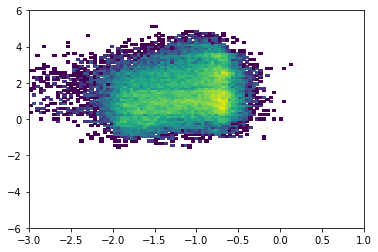

In [83]:
from matplotlib.colors import LogNorm
plt.hist2d((bright_phot['MAG_APER3'] - bright_phot['MAG_APER1']), -2.5*np.log10(bright_phot['BACKGROUND']), bins=(np.linspace(-3,1,100), np.linspace(-6,6,100)), norm=LogNorm())

plt.show()

In [84]:
((phot_df['MAG_APER3'] - phot_df['MAG_APER1'])<-1).groupby(['Filter']).sum()

Filter
F336W    25575.0
F438W    11333.0
F555W    27552.0
F656N    18677.0
F814W    13138.0
dtype: float64

In [85]:
df = pd.DataFrame({'X' : all_stars[all_stars['eha_2'] < 0.15]['v_1'] - all_stars[all_stars['eha_2'] < 0.15]['i_1'], 'Y' : all_stars[all_stars['eha_2'] < 0.15]['v_1'] - all_stars[all_stars['eha_2'] < 0.15]['ha_1']})  #we build a dataframe from the data
_, bins=pd.qcut(df.X,70, retbins=True)
data_cut = pd.cut(df.X,bins)           #we cut the data following the bins
grp = df.groupby(by = data_cut)        #we group the data by the cut

ret = grp.aggregate(np.median)         #we produce an aggregate representation (median) of each bin
#plt.scatter(df.X,df.Y,color='k',alpha=.2,s=2)
#plt.plot(ret.X,ret.Y,'r--',lw=4,alpha=.8)

fit = np.polyfit(ret.X,ret.Y, 4)
#plt.plot(ret.X,np.poly1d(fit)(ret.X))
#plt.ylim(-0.5,7)
#plt.xlim(-0.5,3)
#plt.show()

def running_median(VI_color):
    return np.poly1d(fit)(VI_color)

In [86]:
df= Analyzer.merge_color_maxha('F555W','F814W')

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:269: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


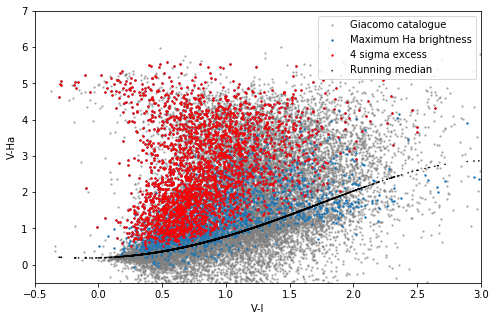

2648


In [87]:
plt.figure(figsize=(8,5))
plt.ylim(-0.5,7)
plt.xlim(-0.5,3)
five_sigma_excess = ((df.F555W-df.MaxHa) - running_median(df.F555W-df.F814W))/np.sqrt((df.eColor**2+df.HaErr**2))>=4
#plt.scatter((Analyzer.MedMag.unstack()['F555W'] - Analyzer.MedMag.unstack()['F814W']),(Analyzer.MedMag.unstack()['F555W'] - Analyzer.MedMag.unstack()['F656N']), s=1, label='Median colors')
plt.scatter(all_stars['v_1']-all_stars['i_1'], all_stars['v_1']-all_stars['ha_1'], color='grey', s=2,alpha=0.5, label='Giacomo catalogue')
plt.scatter(df.F555W-df.F814W, df.F555W-df.MaxHa, s=2, label='Maximum Ha brightness')
plt.scatter((df.F555W-df.F814W)[five_sigma_excess], (df.F555W-df.MaxHa)[five_sigma_excess], s=2, c='red', label='4 sigma excess')
plt.scatter(df.F555W-df.F814W,running_median(df.F555W-df.F814W), color='black', s=1, ls='dotted', label='Running median')
plt.xlabel('V-I')
plt.ylabel('V-Ha')
plt.legend(loc='best')
plt.show()
print(five_sigma_excess.sum())

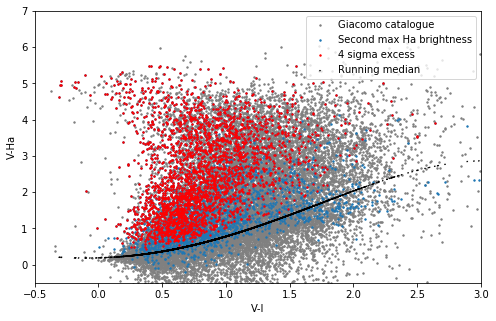

2546


In [88]:
plt.figure(figsize=(8,5))
plt.ylim(-0.5,7)
plt.xlim(-0.5,3)
five_sigma_excess = ((df.F555W-df.SecondMaxHa) - running_median(df.F555W-df.F814W))/np.sqrt((df.eColor**2+df.HaErr**2))>=4
#plt.scatter((Analyzer.MedMag.unstack()['F555W'] - Analyzer.MedMag.unstack()['F814W']),(Analyzer.MedMag.unstack()['F555W'] - Analyzer.MedMag.unstack()['F656N']), s=1, label='Median colors')
plt.scatter(all_stars['v_1']-all_stars['i_1'], all_stars['v_1']-all_stars['ha_1'], color='grey', s=2, label='Giacomo catalogue')
plt.scatter(df.F555W-df.F814W, df.F555W-df.SecondMaxHa, s=2, label='Second max Ha brightness')
plt.scatter((df.F555W-df.F814W)[five_sigma_excess], (df.F555W-df.SecondMaxHa)[five_sigma_excess], s=2, c='red', label='4 sigma excess')
plt.scatter(df.F555W-df.F814W,running_median(df.F555W-df.F814W), color='black', s=1, ls='dotted', label='Running median')

plt.xlabel('V-I')
plt.ylabel('V-Ha')
plt.legend(loc='best')
plt.show()
print(five_sigma_excess.sum())
ha_excess_stars = five_sigma_excess.index[five_sigma_excess].values

890
3985
890


/home/luuk/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:316: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


3985


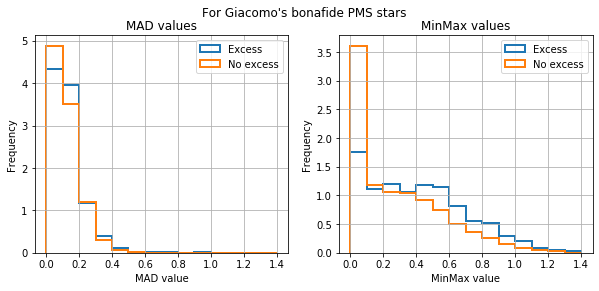

In [89]:
plt.figure(figsize=(10,4))
mads = Analyzer.GetMADvalues()
mads=mads[mads.index.get_level_values(1)=='F656N']
excess_mad = mads.loc[pms_stars.index.values]
print(len(excess_mad))
not_pms = np.setdiff1d(mads.reset_index().AssocID, pms_stars.index.values)
not_pms = np.setdiff1d(not_pms, ha_excess_stars)
not_excess_mad = mads.loc[not_pms]
print(len(not_excess_mad))
plt.subplot(121)

plt.title('MAD values')
excess_mad.hist(bins=np.arange(0,1.5,0.1), histtype='step', label='Excess', normed=True, linewidth=2)
not_excess_mad.hist(bins=np.arange(0,1.5,0.1), histtype='step', label='No excess', normed=True, linewidth=2)

plt.suptitle("For Giacomo's bonafide PMS stars")
plt.legend()
plt.xlabel('MAD value')
plt.ylabel('Frequency')

plt.subplot(122)
plt.title('MinMax values')
minmax = Analyzer.GetMinMaxvalues()
minmax=minmax[minmax.index.get_level_values(1)=='F656N']
excess_minmax = minmax.loc[pms_stars.index.values]
print(len(excess_mad))
not_pms = np.setdiff1d(minmax.reset_index().AssocID, pms_stars.index.values)
not_pms = np.setdiff1d(not_pms, ha_excess_stars)
not_excess_minmax = minmax.loc[not_pms]
print(len(not_excess_minmax))

excess_minmax.hist(bins=np.arange(0,1.5,0.10), histtype='step', label='Excess', normed=True, linewidth=2)
not_excess_minmax.hist(bins=np.arange(0,1.5,0.10), histtype='step', label='No excess', normed=True, linewidth=2)

plt.legend()
plt.xlabel('MinMax value')
plt.ylabel('Frequency')
plt.show()

In [90]:
data = Analyzer.get_max_ha().dropna()
MaxMin = data.MinHa - data.MaxHa
MaxMin2 = data.SecondMinHa - data.MaxHa
Max2Min = data.MinHa - data.SecondMaxHa
Max2Min2 = data.SecondMinHa - data.SecondMaxHa

2546
3985
2546
3985


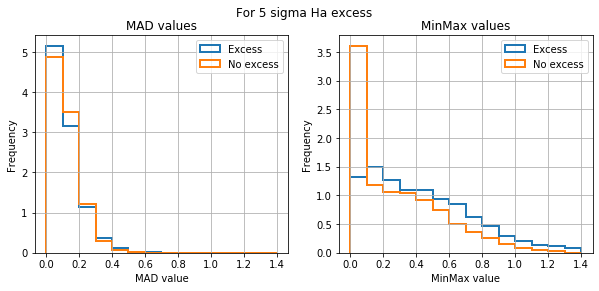

In [91]:
plt.figure(figsize=(10,4))
mads = Analyzer.GetMADvalues()
mads=mads[mads.index.get_level_values(1)=='F656N']
excess_mad = mads.loc[ha_excess_stars]
print(len(excess_mad))

not_pms = np.setdiff1d(mads.reset_index().AssocID, pms_stars.index.values)
not_pms = np.setdiff1d(not_pms, ha_excess_stars)
not_excess_mad = mads.loc[not_pms]

print(len(not_excess_mad))
plt.subplot(121)
excess_mad.hist(bins=np.arange(0,1.5,0.1), histtype='step', label='Excess', normed=True, linewidth=2)
not_excess_mad.hist(bins=np.arange(0,1.5,0.1), histtype='step', label='No excess', normed=True, linewidth=2)
plt.title('MAD values')

plt.suptitle('For 5 sigma Ha excess')
plt.legend()
plt.xlabel('MAD value')
plt.ylabel('Frequency')

plt.subplot(122)
plt.title('MinMax values')
minmax = Analyzer.GetMinMaxvalues()
minmax=minmax[minmax.index.get_level_values(1)=='F656N']
excess_minmax = minmax.loc[ha_excess_stars]
print(len(excess_mad))
not_pms = np.setdiff1d(minmax.reset_index().AssocID, pms_stars.index.values)
not_pms = np.setdiff1d(not_pms, ha_excess_stars)
not_excess_minmax = minmax.loc[not_pms]
print(len(not_excess_mad))

excess_minmax.hist(bins=np.arange(0,1.5,0.1), histtype='step', label='Excess', normed=True, linewidth=2)
not_excess_minmax.hist(bins=np.arange(0,1.5,0.1), histtype='step', label='No excess', normed=True, linewidth=2)
plt.legend()
plt.xlabel('MinMax value')
plt.ylabel('Frequency')
plt.savefig('5sigma_excess_mad_minmax.png', dpi=500)
plt.show()

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the

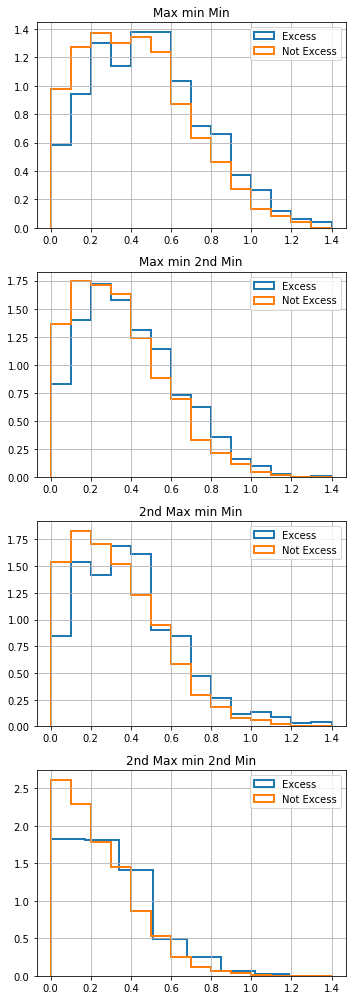

In [92]:
plt.figure(figsize=(5,14))
plt.subplot(411)
MaxMin.loc[pms_stars.index.values].dropna().hist(bins=np.arange(0,1.5,0.1), histtype='step', label='Excess', normed=True, linewidth=2)
MaxMin.loc[not_pms].dropna().hist(bins=np.arange(0,1.5,0.1), histtype='step', label='Not Excess', normed=True, linewidth=2)
plt.title('Max min Min')
plt.legend()
plt.subplot(412)
MaxMin2.loc[pms_stars.index.values].dropna().hist(bins=np.arange(0,1.5,0.1), histtype='step', label='Excess', normed=True, linewidth=2)
MaxMin2.loc[not_pms].dropna().hist(bins=np.arange(0,1.5,0.1), histtype='step', label='Not Excess', normed=True, linewidth=2)
plt.legend()
plt.title('Max min 2nd Min')
plt.subplot(413)

Max2Min.loc[pms_stars.index.values].dropna().hist(bins=np.arange(0,1.5,0.1), histtype='step', label='Excess', normed=True, linewidth=2)
Max2Min.loc[not_pms].dropna().hist(bins=np.arange(0,1.5,0.1), histtype='step', label='Not Excess', normed=True, linewidth=2)
plt.legend()
plt.title('2nd Max min Min')
plt.subplot(414)

Max2Min2.loc[pms_stars.index.values].dropna().hist(bins=np.arange(0,1.5,0.17), histtype='step', label='Excess', normed=True, linewidth=2)
Max2Min2.loc[not_pms].dropna().hist(bins=np.arange(0,1.5,0.1), histtype='step', label='Not Excess', normed=True, linewidth=2)
plt.legend()
plt.title('2nd Max min 2nd Min')
plt.tight_layout()
plt.show()



In [93]:
a=pd.merge(pd.DataFrame({'MAD':excess_mad}),pms, left_index=True, right_index=True)
for col in a.columns:
    if col.startswith('Lg'):
        a[col.split('Lg')[-1]] = 10**a[col]
a.corr().loc['MAD']

MAD       1.000000
X         0.000703
Y         0.066256
V         0.231333
eV        0.066039
I         0.264899
eI        0.082104
Ha       -0.119325
eHa       0.268707
LgT      -0.001056
eLgT      0.116470
LgL      -0.170720
eLgL      0.117016
LgHa     -0.266109
EW        0.030270
Mass     -0.199621
Age       0.147227
LgMdot   -0.200529
T         0.019186
L        -0.117132
Mdot     -0.084765
Name: MAD, dtype: float64

In [94]:
a=pd.merge(excess_minmax,pms, left_index=True, right_index=True)
a.corr().loc['MAG_APER2']

MAG_APER2    1.000000
X           -0.020981
Y            0.039664
V            0.279985
eV           0.072831
I            0.307452
eI           0.053897
Ha           0.314108
eHa          0.295552
LgT         -0.046182
eLgT         0.068504
LgL         -0.218949
eLgL         0.069653
LgHa        -0.303394
EW           0.025553
Mass        -0.218677
Age          0.142031
LgMdot      -0.227408
Name: MAG_APER2, dtype: float64

In [95]:
df = Analyzer.get_mad_mag_nom()

In [96]:
df[(df.Nmeas>5)&(df.index.get_level_values(1)=='F656N')].sort_values(by='MAD').dropna().tail(15)

,,MAG_APER2,MAD,Nmeas,MADSigma
AssocID,Filter,,,,
1714,F656N,18.672968,0.438168,7,14.298405
832,F656N,16.448151,0.445931,8,14.467929
9405,F656N,21.065742,0.448051,8,16.575690
7320,F656N,17.327259,0.449058,6,14.911861
3856,F656N,18.901989,0.449855,6,13.221010
2531,F656N,18.443478,0.468706,6,15.294944
9978,F656N,21.275061,0.472467,7,17.478960
1593,F656N,18.590086,0.479519,7,15.647791
5537,F656N,19.675528,0.491881,7,16.826965


84.6280969 -69.0765771
../SingleFrame_DetRegrid/WFC2_crcleaned/ib6wd1rrq_crclean_rate_wfc2.fits    197.78195    1400.279
../SingleFrame_DetRegrid/WFC2_crcleaned/ib6wd2btq_crclean_rate_wfc2.fits    191.72574    1400.4441
../SingleFrame_DetRegrid/WFC2_crcleaned/ib6wd3fdq_crclean_rate_wfc2.fits    204.24615    1442.3905
../SingleFrame_DetRegrid/WFC2_crcleaned/ib6wd7hdq_crclean_rate_wfc2.fits    210.26329    1443.2418
../SingleFrame_DetRegrid/WFC2_crcleaned/ib6wd6e9q_crclean_rate_wfc2.fits    207.84625    1398.4802
../SingleFrame_DetRegrid/WFC2_crcleaned/ib6wr8jhq_crclean_rate_wfc2.fits    216.962    1439.61


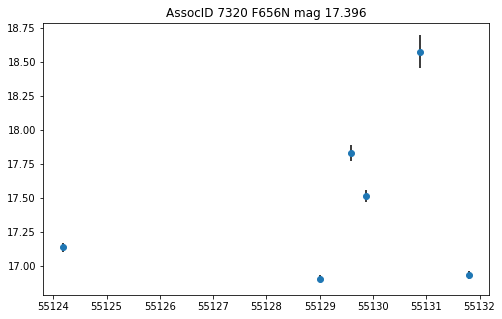

In [98]:
#stars = df[(df.Nmeas>7)&(df.MADSigma>25)&(df.index.get_level_values(1)=='F656N')&(df.MAD>0.25)].index.get_level_values(0)
#Timeseries = [Analyzer.GetTimeSeries(w, 'F656N') for w in stars]
Analyzer.inspect(7320, 'F656N')

In [105]:
from scipy import stats

a = np.random.randn(50,50)

%timeit m = np.median(a)

43.3 µs ± 700 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


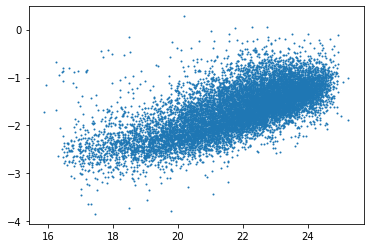

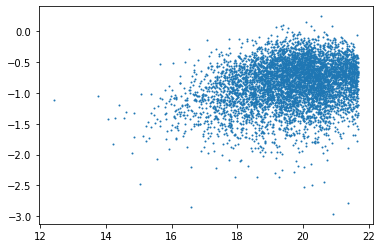

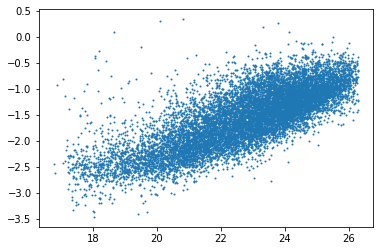

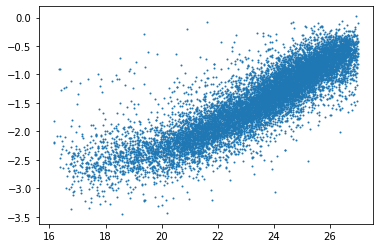

In [128]:
a=Analyzer.median_mad_sigma()
a=a[a.index.get_level_values(1)=='F814W']
plt.scatter(a.MAG, np.log10(a.MAD), s=1)
plt.show()

a=Analyzer.median_mad_sigma()
a=a[a.index.get_level_values(1)=='F656N']
plt.scatter(a.MAG, np.log10(a.MAD), s=1)
plt.show()

a=Analyzer.median_mad_sigma()
a=a[a.index.get_level_values(1)=='F555W']
plt.scatter(a.MAG, np.log10(a.MAD), s=1)
plt.show()

a=Analyzer.median_mad_sigma()
a=a[a.index.get_level_values(1)=='F438W']
plt.scatter(a.MAG, np.log10(a.MAD), s=1)
plt.show()

In [130]:
medmag = Analyzer.GetMedMags().unstack()

VminI = medmag.F555W-medmag.F814W
Vmag  = medmag.F555W

medmag = medmag.join(a[a.index.get_level_values(1)== 'F656N']['MAD'])

medmag = medmag.join(a[a.index.get_level_values(1)== 'F656N']['Nmeas'])
medmag = medmag.sort_values(ascending=False, by='MAD')
medmag['VminI'] = medmag.F555W-medmag.F814W
medmag['VminHa'] = medmag.F555W-medmag.F656N
medmag = medmag[medmag.Nmeas>2]

KeyError: 'Nmeas'

KeyError: 'VminI'

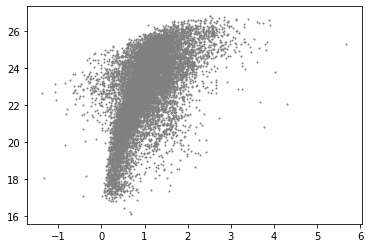

In [131]:
plt.scatter(VminI, Vmag, s=1, color='grey')
plt.scatter(medmag['VminI'][medmag.MAD>0.5], medmag['F555W'][medmag.MAD>0.5], s=2, color='red')

plt.ylim(26,15)
plt.xlim(-0.5,3)
plt.show()

In [132]:
xpoints = medmag['VminI']
ypoints = medmag['VminHa']

mask = (np.isfinite(xpoints))&(np.isfinite(ypoints))&(~np.isnan(xpoints))&(~np.isnan(ypoints))
xpoints = xpoints[mask]
ypoints = ypoints[mask]

KeyError: 'VminI'

In [133]:
plt.scatter(xpoints, ypoints, s=1, color='grey')
plt.scatter(medmag['VminI'][medmag.MAD>0.5], medmag['VminHa'][medmag.MAD>0.5], s=3, color='red')
#plt.scatter(medmag['VminI'][medmag.MAD>0.3], medmag['F555W'][medmag.MAD>0.3], s=1, color='red')
plt.ylim(-0.5,7)
plt.xlim(-0.5,3)
plt.show()

NameError: name 'xpoints' is not defined

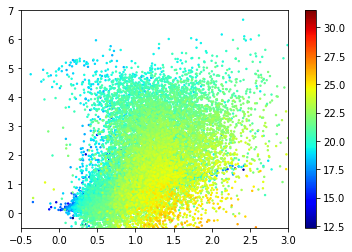

In [134]:
from mpl_toolkits.mplot3d import Axes3D
plt.scatter(all_stars['v_1'] - all_stars['i_1'],all_stars['v_1'] - all_stars['ha_1'],cmap='jet', s=2, c=all_stars['ha_1'])
#plt.scatter(medmag['F555W'] - medmag['F814W'],medmag['F555W'] - medmag['F656N'], s=1, c='red')
plt.colorbar()
plt.ylim(-0.5,7)
plt.xlim(-0.5,3)
plt.show()


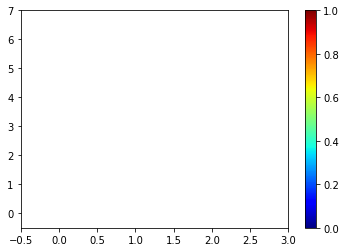

In [135]:
from mpl_toolkits.mplot3d import Axes3D
#plt.scatter(all_stars['v_1'] - all_stars['i_1'],all_stars['v_1'] - all_stars['ha_1'],cmap='jet', s=2, c=all_stars['ha_1'])
plt.scatter(medmag['F555W'] - medmag['F814W'],medmag['F555W'] - medmag['F656N'], s=1, cmap='jet', c=medmag['F656N'])
plt.colorbar()
plt.ylim(-0.5,7)
plt.xlim(-0.5,3)
plt.show()

In [136]:
medmag[medmag.Nmeas>4]['F656N']

AttributeError: 'DataFrame' object has no attribute 'Nmeas'

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


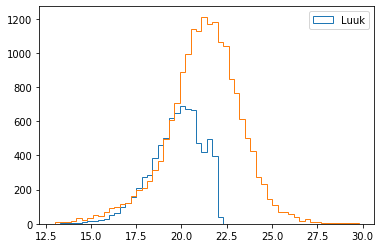

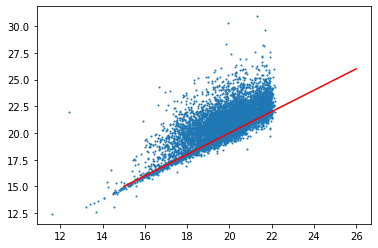

In [143]:
F656mags = Analyzer.GetMedMags()[Analyzer.GetMedMags().index.get_level_values(1)=='F656N'].droplevel(1)
merged = pd.merge(F656mags,all_stars['ha_1'], left_index=True, right_index=True, how='outer')
plt.hist(merged['MAG_APER2'], histtype='step', normed=False, label='Luuk', bins=np.arange(13,30,0.3))
plt.hist(merged['ha_1'], histtype='step', normed=False, bins=np.arange(13,30,0.3))
plt.legend()
plt.show()
plt.scatter(merged.dropna()['MAG_APER2'], merged.dropna()['ha_1'], s=1)
plt.plot([15,26],[15,26], color='red')

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


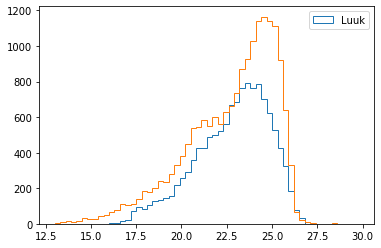

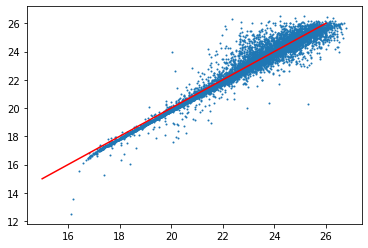

In [138]:
F555mags = Analyzer.GetMedMags()[Analyzer.GetMedMags().index.get_level_values(1)=='F555W'].droplevel(1)
merged = pd.merge(F555mags,all_stars['v_1'], left_index=True, right_index=True, how='outer')
plt.hist(merged['MAG_APER2'], histtype='step', normed=False, label='Luuk', bins=np.arange(13,30,0.3))
plt.hist(merged['v_1'], histtype='step', normed=False, bins=np.arange(13,30,0.3))
plt.legend()
plt.show()
plt.scatter(merged.dropna()['MAG_APER2'], merged.dropna()['v_1'], s=1)
plt.plot([15,26],[15,26], color='red')

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


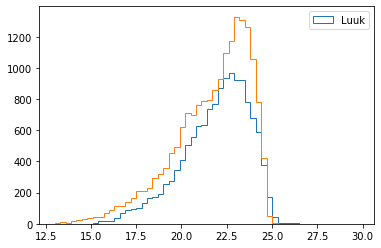

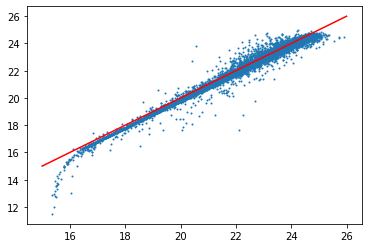

In [139]:
F814mags = Analyzer.GetMedMags()[Analyzer.GetMedMags().index.get_level_values(1)=='F814W'].droplevel(1)
merged = pd.merge(F814mags,all_stars['i_1'], left_index=True, right_index=True, how='outer')
plt.hist(merged['MAG_APER2'], histtype='step', normed=False, label='Luuk', bins=np.arange(13,30,0.3))
plt.hist(merged['i_1'], histtype='step', normed=False, bins=np.arange(13,30,0.3))
plt.legend()
plt.show()
plt.scatter(merged.dropna()['MAG_APER2'], merged.dropna()['i_1'], s=1)
plt.plot([15,26],[15,26], color='red')

In [105]:
a=phot_df.reset_index().groupby(['AssocID', 'Filter'])['T_Start'].nunique().sort_values(ascending=False)
a=a.reset_index()
a[a.Filter=='F656N']

,AssocID,Filter,T_Start
33176,2503,F656N,8
33177,1279,F656N,8
33183,558,F656N,8
33184,407,F656N,8
33186,559,F656N,8
...,...,...,...
43991,1882,F656N,1
44000,12748,F656N,1
44006,7020,F656N,1
44010,1846,F656N,1


In [106]:
a=red_giants.sort_values(by='ha_1').join(Analyzer.GetNumberOfMeasurements().unstack()['F814W'])

In [107]:
a=a.join(Analyzer.GetMADvalues().unstack()['F814W'], rsuffix='_mad')

In [108]:
a.sort_values(by='F814W_mad', ascending=False)

,x,y,RA,Dec,u_1,eu_2,b_1,eb_2,v_1,ev_2,i_1,ei_2,ha_1,eha_2,F814W,F814W_mad
ID,,,,,,,,,,,,,,,,
2666,1137.158,4772.506,84.734324,-69.053835,21.548,0.027,20.944,0.021,19.939,0.027,18.640,0.025,18.898,0.166,8.0,0.232616
2453,980.060,954.809,84.739178,-69.095195,21.275,0.033,20.718,0.028,19.755,0.016,18.534,0.024,18.817,0.033,16.0,0.116446
3831,474.268,1558.237,84.754516,-69.088652,22.874,0.036,21.913,0.022,20.698,0.015,19.053,0.017,19.471,0.028,15.0,0.092201
3358,3261.373,1515.568,84.669917,-69.089125,22.253,0.034,21.565,0.023,20.429,0.020,18.842,0.018,19.285,0.037,16.0,0.088863
3738,540.703,1898.091,84.752489,-69.084971,22.981,0.025,21.927,0.024,20.647,0.017,19.014,0.022,19.439,0.039,16.0,0.088049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2280,2174.449,1007.840,84.702913,-69.094627,20.903,0.034,20.484,0.026,19.593,0.020,18.383,0.023,18.811,0.057,12.0,0.002384
2780,2768.261,1246.584,84.684884,-69.092040,21.556,0.045,20.990,0.020,20.017,0.022,18.670,0.017,19.142,0.047,11.0,0.002374
4425,2900.976,440.791,84.680852,-69.100770,23.115,0.091,22.246,0.029,21.010,0.025,19.244,0.016,19.954,0.378,13.0,0.002275


84.6450952 -69.0769518
../SingleFrame_DetRegrid/WFC2/ib6wd1sgq_flt_wfc2_pamcorr_rate.fits    736.7258    1576.2131
../SingleFrame_DetRegrid/WFC2/ib6wd1siq_flt_wfc2_pamcorr_rate.fits    736.7634    1576.3971
../SingleFrame_DetRegrid/WFC2/ib6wd4ldq_flt_wfc2_pamcorr_rate.fits    723.008    1535.2898
../SingleFrame_DetRegrid/WFC2/ib6wd4lfq_flt_wfc2_pamcorr_rate.fits    723.014    1535.2347
../SingleFrame_DetRegrid/WFC2/ib6wd2cjq_flt_wfc2_pamcorr_rate.fits    730.18744    1577.1179
../SingleFrame_DetRegrid/WFC2/ib6wd2clq_flt_wfc2_pamcorr_rate.fits    730.22253    1577.1172
../SingleFrame_DetRegrid/WFC2/ib6wd3fvq_flt_wfc2_pamcorr_rate.fits    728.1371    1533.6152
../SingleFrame_DetRegrid/WFC2/ib6wd3fxq_flt_wfc2_pamcorr_rate.fits    728.0117    1533.5596
../SingleFrame_DetRegrid/WFC2/ib6wd5gvq_flt_wfc2_pamcorr_rate.fits    740.62115    1576.9479
../SingleFrame_DetRegrid/WFC2/ib6wd5gxq_flt_wfc2_pamcorr_rate.fits    740.6256    1577.0359
../SingleFrame_DetRegrid/WFC2/ib6wd7hvq_flt_wfc2_pamcorr

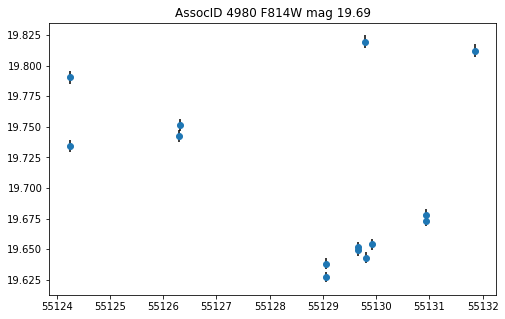

In [109]:
#Analyzer.inspect(3242, 'F656N')
#Analyzer.inspect(3119, 'F656N')
#Analyzer.inspect(3411, 'F814W')
#Analyzer.inspect(2067, 'F656N')
Analyzer.inspect(4980, 'F814W')
#Analyzer.inspect(2196, 'F656N')

In [955]:
def create_lightcurve(T, randmodel):
    base_mag = 18
    if randmodel == 'sin':
        amp = np.random.randn()*0.4 + 0.5
        freq = np.random.randn()+0.5
        phaseshift = np.random.randn()*3.14
        lightcurve = amp*np.sin(freq*T-phaseshift) + 0.1*np.random.randn(len(T))+base_mag
    if randmodel=='heavyside2':
        amp = np.random.randn()*0.1 + 0.4
        probs = np.random.randn(3)*0.1+0.33
        probs = np.array([max(0,min(w,1)) for w in probs])
        probs = probs / np.nansum(probs)
        lightcurve = base_mag + 0.3*np.random.choice([-1,0,1],size=8, p=probs)+ 0.1*np.random.randn(len(T))
    if randmodel=='heavyside1':
        amp = np.random.randn()*0.1 + 0.4
        probs = np.random.randn(2)*0.1+0.5
        probs = np.array([max(0,min(w,1)) for w in probs])
        probs = probs / np.nansum(probs)
        lightcurve = base_mag + 0.3*np.random.choice([-1,0],size=8, p=probs)+ 0.1*np.random.randn(len(T))
    if randmodel == 'constant':
        lightcurve = base_mag + 0.1*np.random.randn(len(T))
    if randmodel == 'delta':
        npeaks = np.random.randint(0,5)
        lightcurve = base_mag + 0.1*np.random.randn(len(T))
        peaks = np.random.choice(range(0,8),size=npeaks)
        for peak in peaks:
            lightcurve[peak] -= (np.random.randn()*0.2+0.5)
    if randmodel == 'triangular':
        lightcurve = base_mag - 0.4*signal.triang(8)+ 0.1*np.random.randn(len(T)) 
    return lightcurve

def mad(vals):
    return np.median(np.abs(vals - np.median(vals)))

def minmax(vals):
    vals = np.sort(vals)[1:-1]
    return np.max(vals) - np.min(vals)


In [568]:
T = np.array([55124.18571567, 55126.24902567, 55129.00696583, 55129.59410694,
       55129.73546102, 55129.87522953, 55130.87543805, 55131.80321583])
from scipy import signal

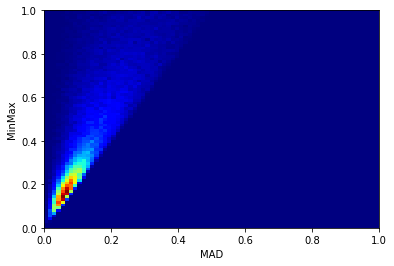

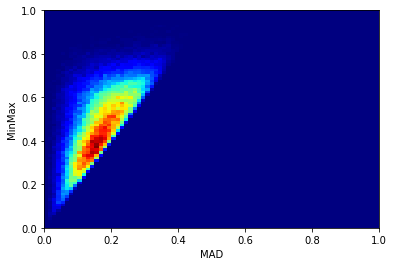

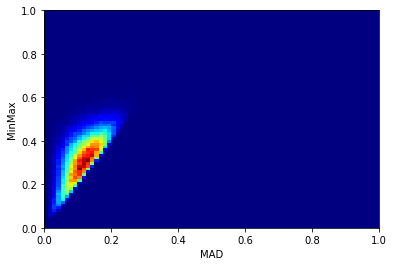

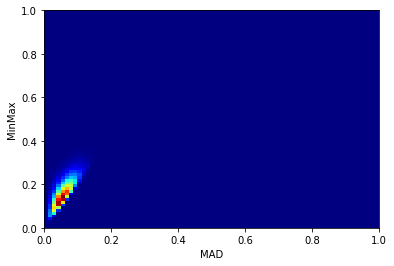

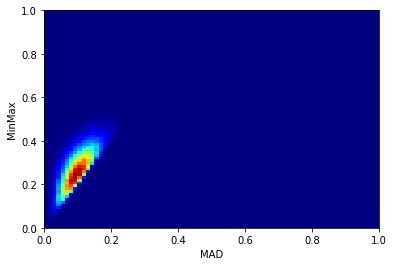

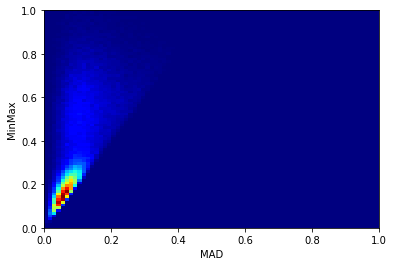

In [957]:
for model in ['sin', 'heavyside2', 'heavyside1', 'constant', 'triangular', 'delta']:
    madvals=[]
    minmaxvals=[]
    for simulation in range(100000):
        lightcurve = create_lightcurve(T, model)
        madval = mad(lightcurve)
        madvals.append(madval)
        minmaxval = minmax(lightcurve)
        minmaxvals.append(minmaxval)
    plt.xlabel('MAD')
    plt.ylabel('MinMax')
    plt.hist2d(madvals, minmaxvals,bins=(np.linspace(0,1,80),np.linspace(0,1,80)), cmap='jet')
    plt.show()

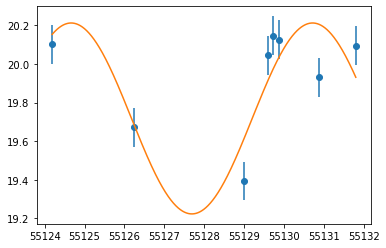

In [569]:
def sin(x, a, b, c,d):
    return a*np.sin(b*x-c)+d
from scipy.optimize import curve_fit
popt, pcov = curve_fit(sin, T, np.array([20.10210643, 19.67172777, 19.39368394, 20.04486941, 20.14697961,
       20.12556658, 19.93001961, 20.09496191]), sigma=8*[0.1])

plt.scatter(T, np.array([20.10210643, 19.67172777, 19.39368394, 20.04486941, 20.14697961,
       20.12556658, 19.93001961, 20.09496191]))
plt.errorbar(T, np.array([20.10210643, 19.67172777, 19.39368394, 20.04486941, 20.14697961,
       20.12556658, 19.93001961, 20.09496191]), yerr=0.1, ls='none')

x=np.linspace(min(T), max(T), 10000)
plt.plot(x, sin(x, *popt))

In [ ]:
LuukBackground = (np.pi*3.25**2) * (phot_df2['FLUXERR_BGOuter'] - phot_df2['FLUXERR_BGInner']) / (np.pi*7**2 - np.pi*4**2)
corrmags = -2.5*np.log10(phot_df2['FLUX_APER2'] + phot_df2['BACKGROUND'] - LuukBackground) + [zmag[w] for w in phot_df2.index.get_level_values(1)]
corrmags - phot_df['MAG_APER2']

In [927]:
We / I forgot one thing about the figure we had back in our skype. Since we are selecting on bonafide PMS stars using Ha excess, we are inferring a bias in that sample: to have Ha excess, their relative Ha magnitude must be bright to have excess. Thats perfectly fine. However, this means that we will in general have more measurements for those stars. Stars with only one measurement 

SyntaxError: invalid syntax (<ipython-input-927-4bf0ca2c6b6d>, line 1)